# Code Assigment 1

For this assignment you will use the following SVM implementation for classifying these datasets:


https://archive.ics.uci.edu/ml/datasets/banknote+authentication


https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

You should:

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3) Please answer the following questions: a) Are these datasets linearly separable? b) Are these datasets randomly chosen and c) The sample size is enough to guarantee generalization.

4) Provide an explanation how and why the code is working. You can add comments and/or formal explanations into the notebook.

5) Show some examples to illustrate that the method is working properly.

6) Provide quantitative evidence for generalization using the provided dataset.


In [ ]:
# https://pythonprogramming.net/svm-optimization-python-2-machine-learning-tutorial/?completed=/svm-optimization-python-machine-learning-tutorial/
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    # train
    def fit(self, data):
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],
                      [-1,1],
                      [-1,-1],
                      [1,-1]]

        all_data = []
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # support vectors yi(xi.w+b) = 1
        

        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense:
                      self.max_feature_value * 0.001,]

        
        
        # extremely expensive
        b_range_multiple = 5
        # we dont need to take as small of steps
        # with b as we do w
        b_multiple = 5
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])
            # we can do this because convex
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True
                        # weakest link in the SVM fundamentally
                        # SMO attempts to fix this a bit
                        # yi(xi.w+b) >= 1
                        # 
                        # #### add a break here later..
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                # Verifiy constraints
                                if not yi*(np.dot(w_t,xi)+b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            # Computes norm
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    print('Optimized a step.')
                else:
                    w = w - step

            norms = sorted([n for n in opt_dict])
            #||w|| : [w,b]
            opt_choice = opt_dict[norms[0]]
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]+step*2
            

    def predict(self,features):
        # sign( x.w+b )
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        return classification
        
        
data_dict = {-1:np.array([[1,7],
                          [2,8],
                          [3,8],]),
             
             1:np.array([[5,1],
                         [6,-1],
                         [7,3],])}

svm1 = Support_Vector_Machine()
svm1.fit(data_dict)


# Solution

## Code explanation

**What do we want to solve?**: Let $\{\bigl( \textbf{x}_{i}, y_{i}\bigl)\}$ be our dataset for a binary classification problem where $\textbf{x}_{i} \in \mathbb{R}^{d}$ and $y \in \{0, 1\}$. We want to find a model (function) able to classify a not previously observed $x_{j}$ into one of the two clases where the $y_{i}$ belong. One of the Machine Learning (ML) models that works for this kind of problems is ***Support Vector Machine*** (SVM). In SVM the main idea is to find a hyperplane that maximizes the distance between the two sets of data points and still properly classify each data point; generally, we want to solve the following optimization problem:
$$
 \min \frac{\lVert \textbf{w} \rVert^{2}}{2}, \text{  such that  } y_{i}(\textbf{x}_{i} \textbf{w} - b) \gt 1, i = 1, ..., N,
$$
where $\textbf{w} \in \mathbb{R}^{d}$ and $b \in \mathbb{R}$. Since $\frac{\lVert \textbf{w} \rVert^{2}}{2}$ is a strictly convex function, we have the guarantee on the existence and uniqueness of a global minimum <cite id="wugzm"><a href="#zotero%7C14215332%2FV9BN9UHV">(Dattorro, 2019)</a></cite>.

**Code process explanation**:
1. We begin with our dataset $\{\bigl( \textbf{x}_{i}, y_{i}\bigl)\}$.


2. We define a set of transformations named `transforms`. Since we are trying to minimize $\frac{\lVert \textbf{w} \rVert^{2}}{2}$, there are infinite vectors that can have the same norm as $w$ but only one of them is going to satisfy the problem's conditions. 
Therefore, if we choose a possible vector $w$, we must verify if this or any of the vectors that have the same norm verifies the conditions. From here, we will store in `opt_dict` only the information of such vectors. Since for each vector $w$ there exists an infinite set of vectors having its same norm, we will only evaluate some transformations of $w$ (these transformations preserve the vector norm). *Note:* Please be aware that limiting the possible shapes that vector $w$ can take may result in the algorithm being unable to identify a separating hyperplane for certain types of data.


3. We generate a set of guesses for $w$ and $b$. $w$ will always be a vector with all its entries equal to each other (in general, it may not be the case).  Initially, its entries will be equal to the largest value among all data features multiplied by 10 (this is just a way to initialize the data, by the type of function it is guaranteed that given any $w$ the proper optimization algorithm must find the minimum of the function). The general idea is to be able to start with large steps for the vector $w$, so that we initially approach the minimum quickly and as the vector gets smaller (its entries), start moving slower towards the minimum so that the algorithm has no jumps finding the optimum. The case of $b$ is similar to that of $w$, we start with a fairly large range (it also depends on the maximum of all the features of the data) and as we go through the possible values, we make the range smaller. The vector $w$ is updated using a gradient descent type algorithm (it is not properly gradient descent because we are not taking into account the direction of the gradient of the loss function). *Note:* In general, the optimization done to find the parameters $w$ and $b$ is not the appropriate one, it should be done using the method of the Lagrange multipliers.

In general terms, the approach of the algorithm consists of generating a set of $w$ vectors and $b$ values that are evaluated exhaustively, retaining only those that satisfy the constraints of the optimization problem, and finally selecting the optimal values that minimize the norm of $w$.

**Notes on the code:**
1. Since the code was created to classify $\textbf{x}_{i}$ such that $\textbf{x}_{i} \in \mathbb{R}^{2}$, we made some modifications to it so it can work for $\textbf{x}_{i} \in \mathbb{R}^{d}$ where $d \in \mathbb{N}$.
2. In the original code, they wanted to plot the data points to interpret the results, since we will working with data points with more than 3 dimensions, we will not able to plot them, so we removed the plotting part from the code.
3. Most of the original comments were deleted. 
4. We added the docstring for each function and for the class created.

The following code is a basic SVM algorithm implementation.

In [1]:
import numpy as np
from itertools import permutations

##  This function will help us create automatically the transforms list of lists.
def unique_permutations(iterable, r=None):
    '''
    Creates a list of lists of all (r) permutations of a  set of elements (iterable).

    Parameters
    ----------
    iterable : any type of Python iterable as list, tuple or string
        Stores the elements of the permutation

    r : int
        Number of elements to use in the permutation     
    
    Returns
    ----------
    transforms : list
        Permutations 
    '''
    previous = tuple()
    transforms = []
    for p in permutations(sorted(iterable), r):
        if p > previous:
            previous = p
            transforms.append(list(p))
    
    return transforms  

class Support_Vector_Machine:
    """
    Support Vector Machine model.

    ...

    Attributes
    ----------
    b_range_multiple : int 
            Parameter to help optimize the value of b
            
    b_multiple : int 
        Parameter to help optimize the value of b   

    Methods
    -------
    fit(X, y):
        Fit the Support Vector Machine Model
    
    predict(features):
        Predict using the Support Vector Machine Model
    
    """
    
    def __init__(self, b_range_multiple = 5, b_multiple = 5):            
        '''
        Initializes an object of the class of Support Vector Machine.

        Parameters
        ----------
        b_range_multiple : int 
            Parameter to help optimize the value of b
            
        b_multiple : int 
            Parameter to help optimize the value of b       
        '''
        
        self.b_range_multiple = b_range_multiple
        self.b_multiple = b_multiple        
    
    def fit(self, X, y):
        '''
        Fit the Support Vector Machine Model

        Parameters
        ----------
        X : (array-like, matrix) of shape (n_samples, n_features)
            Training data
            
        y : (array-like, matrix) of shape (n_features, 1) or (n_samples, n_targets)
            Classes of the samples           
        '''
        
        self.data = X
        self.classes = y
        
        ## In this dictionary (opt_dict), we store the norm of the vector w, along with the values of w and b.
        ## At the end of the iterations, we will choose the lowest norm of all the evaluated w vectors,
        ## from this we will choose our optimized parameters.
        opt_dict = {}
        
        transforms = unique_permutations(self.data.shape[1]*[1] + self.data.shape[1]*[-1], self.data.shape[1])
        
        ## Since our data X is a numpy array, we can find the max (min) of it using the function np.amax (np.amin),
        ## meaning theres is no need to iterate over all the array and create a new list "all_data" for this.
        
        # all_data = []
        # for yi in self.data:
        #     for featureset in self.data[yi]:
        #         for feature in featureset:
        #             all_data.append(feature)

        self.max_feature_value = np.amax(self.data)
        self.min_feature_value = np.amin(self.data)
        # all_data = None            

        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,                      
                      self.max_feature_value * 0.001]
        
        
        b_range_multiple = self.b_range_multiple
        b_multiple = self.b_multiple
        latest_optimum = self.max_feature_value*10

        for step in step_sizes:
            w = np.full((self.data.shape[1],), latest_optimum)          
            optimized = False
            while not optimized:
                for b in np.arange(-1*(self.max_feature_value*b_range_multiple),
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True                        
                        
                        ## Since our data X and classes y are numpy arrays, we can avoid having two nested for statements.
                        ## Also, if for one x_i the condition of yi*(np.dot(w_t,xi)+b) >= 1 is not satisfied,
                        ## we should stop the verification for the rest of samples, that's why we added a break 
                        ## statement after the "found_option = False" line.
                        
                        # for i in self.data:
                        #     for xi in self.data[i]:
                        #         yi=i
                        #         # Verifiy constraints
                        #         if not yi*(np.dot(w_t,xi)+b) >= 1:
                        #             found_option = False
                        
                        for i in range(len(self.data)):
                            yi = self.classes[i]
                            xi = self.data[i]
                                # Verifiy constraints
                            if not yi*(np.dot(w_t,xi)+b) >= 1:
                                found_option = False
                                break
                                    
                        if found_option:
                            # Computes norm
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0:
                    optimized = True
                    ## Since we will be working with large datasets, we will avoid printing the following line
                    # print('Optimized a step.')
                else:
                    ## Here we update the value of w with kind of gradient descent algorithm.    
                    ## Note: We should be using the method of Lagrange multipliers (useful for optimization with 
                    ## constraints)  to convert this problem into an unconstraint optimization problem
                    w = w - step

            
            if len(opt_dict)>0:
                norms = sorted([n for n in opt_dict])
                #||w|| : [w,b]                
                opt_choice = opt_dict[norms[0]]
                self.w = opt_choice[0]
                self.b = opt_choice[1]
                latest_optimum = opt_choice[0][0]+step*2
            else:
                self.w = w
                self.b = b
                latest_optimum = w+step*2
            
            

    def predict(self, features):
        '''
        Predict using the Support Vector Machine Model

        Parameters
        ----------
        X : (array-like, matrix) of shape (n_samples, n_features)
            The data matrix for which we want to get the predictions
        Returns
        ----------
        y_pred : (ndarray) of shape (n_features,)
            Predictions for X         
        '''
        # sign( x.w+b )
        y_pred = np.sign(np.dot(features, self.w)+self.b)
        return y_pred

Let's test the code with some dummy data.

In [2]:
import pandas as pd

data_dict = {"ft1": [1, 2, 3, 5, 6, 7], "ft2": [7, 8, 8, 1,-1,3], "y":[-1, -1, -1, 1, 1 ,1]}
    
df = pd.DataFrame.from_dict(data_dict)
X = df.copy().iloc[:, :-1].values
y = df.copy().iloc[:, -1].values

In [3]:
svm = Support_Vector_Machine() # Create model
svm.fit(X, y) # Train model

X_test = np.array([[7, 3.5], [3, 9]])
svm.predict(X_test) # Predict data, for the first sample the output should be 1, and for the second one it should be -1

array([ 1., -1.])

The code is now ready to be used with our data.

## Dataset 1: Data Banknote Authentication
**Dataset Description:** The resulting data was obtained from genuine and forged banknote-like image samples. An industrial camera was used for digitization, resulting in final images in the gray-scale, with 400x400 pixels each and a resolution of approximately 660 dpi. To extract features from the images, the Wavelet Transform was used.

***What is the Wavelet Transform?***: The Wavelet Transform decomposes a function into a set of wavelets, which are a wave-like oscillation that is localized in time. Wavelets have two basic properties: scale and location. 

- *Scale* (or dilation) defines how “stretched”  a wavelet is. This property is related to frequency as defined for waves. 
- *Location* defines where the wavelet is positioned in time (or space) <cite id="6qs1n"><a href="#zotero%7C14215332%2FP94ZMVC2">(Talebi, 2020)</a></cite>.


Its main applications are:
- Signal analysis in time–frequency space <cite id="n8u59"><a href="#zotero%7C14215332%2FQ7QXGZ6I">(“Chapter 3 - Compositing, Smoothing, and Gap-Filling Techniques,” 2020)</a></cite>.
- Noise reduction <cite id="u8fq9"><a href="#zotero%7C14215332%2FQ7QXGZ6I">(“Chapter 3 - Compositing, Smoothing, and Gap-Filling Techniques,” 2020)</a></cite>.
- Data compression <cite id="j23aq"><a href="#zotero%7C14215332%2FWXZ9VFIK">(P. de B. Harrington, 2016)</a></cite>.


**Dataset attributes**
1. Variance of Wavelet Transformed image (continuous): The variance of a distribution is a measurement of how far each number in a dataset is from the mean (average), and thus from every other point in the set.
2. Skewness of Wavelet Transformed image (continuous): Skewness is a measure of the asymmetry of a distribution about its mean.
3. Curtosis of Wavelet Transformed image (continuous): Kurtosis is a measure of the tailedness of a distribution. Tailedness is how often outliers occur. 
4. Entropy of image (continuous): Entropy is a statistical measure of randomness that can be used to characterize the texture of the input image. 
5. Class (integer): Indicates whether the banknote is genuine (1) or counterfeit (0).

**Which problem are we trying to solve?**: Taking into account the description of the data, we will be solving a binary classification problem, where the main goal is to predict whether a banknote is genuine or counterfeit based on the information retrieved from an transformed image taken to it.
    

In [2]:
df1 = pd.read_csv("data/banknote_authentication/data_banknote_authentication.txt", sep=",", header=None, 
                  names=["variance", "skewness", "curtosis", "entropy", "class"])
df1.shape

(1372, 5)

**Is the sample size enough to guarantee generalization?** In Machine Learning there is no formula that allows us to find an n for the size of the training set that guarantees generalization in the test data, because this guarantee can only be obtained probabilistically and the conditions for it to be fulfilled are not generally satisfied in practice. Some data scientists use a factor to calculate the initial amount of data they should work with (this factor can be any number such as 10/100/1000 and is multiplied by the number of features in the data set) <cite id="ahxto"><a href="#zotero%7C14215332%2FPR5M3MS2">(Brownlee, 2019)</a></cite><cite id="1p5mi"><a href="#zotero%7C14215332%2FN5CVPJUC">(Dorfman, 2022)</a></cite>. Although this factor provides a baseline for the work, it cannot be guaranteed a priori that the model will perform well with previously unobserved data. Thus, in general, we can state that the sample size of this data set cannot guarantee generalization.

In [3]:
df1.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
target_distribution = pd.DataFrame(df1['class'].value_counts()).rename(columns={'class':'genuine_banknote'})
target_distribution['percent'] = target_distribution['genuine_banknote']/len(df1)*100
target_distribution['percent'] = target_distribution['percent'].round(3)
target_distribution

,genuine_banknote,percent
0,762,55.539
1,610,44.461


In total, we have the information of 1372 banknote images. The distribution of the dataset is almost half-half, meaning that we almost have the same amount of samples for each of the classes. Since the conditions of the SVM model requires the classes of the data to be $\{1, -1\}$, we will change the value of $0$ for $-1$.

In [5]:
df1 = df1.replace({'class': 0}, {'class': -1})
df1.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,-1
1,4.54590,8.1674,-2.4586,-1.46210,-1
2,3.86600,-2.6383,1.9242,0.10645,-1
3,3.45660,9.5228,-4.0112,-3.59440,-1
4,0.32924,-4.4552,4.5718,-0.98880,-1


In [6]:
target_distribution = pd.DataFrame(df1['class'].value_counts()).rename(columns={'class':'genuine_banknote'})
target_distribution['percent'] = target_distribution['genuine_banknote']/len(df1)*100
target_distribution['percent'] = target_distribution['percent'].round(3)
target_distribution

,genuine_banknote,percent
-1,762,55.539
1,610,44.461


In order to have more information about our dataset, we will study if the dataset has any null values, the attributes distributions including some plots of them against the class values.

*Note: Since we will be using this dataset again for the Code Assignment 2, we need to save df1 which contains all the changes made to it.*

In [27]:
df1.to_pickle("./data/banknote_authentication/data_banknote_authentication.pkl") 

**Null values**


For this task we will be using the following function:

In [7]:
def get_missing_data_table(dataframe):
    ''' Return the sum of missing values in dataframe and their percentage '''
    
    total = dataframe.isnull().sum()
    percentage = dataframe.isnull().sum() / dataframe.isnull().count()
    
    missing_data = pd.concat([total, percentage], axis='columns', keys=['TOTAL','PERCENTAGE'])
    return missing_data.sort_index(ascending=True)

In [8]:
# Null values
get_missing_data_table(df1)

,TOTAL,PERCENTAGE
class,0,0.0
curtosis,0,0.0
entropy,0,0.0
skewness,0,0.0
variance,0,0.0


It is good that our dataset does not have any missing value.

**Attributes distribution**

In [9]:
df1.iloc[:, :-1].describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


We note that the range of values is not big $[-13.77, 17.93]$, so we will not need to rescale the data before training the model.

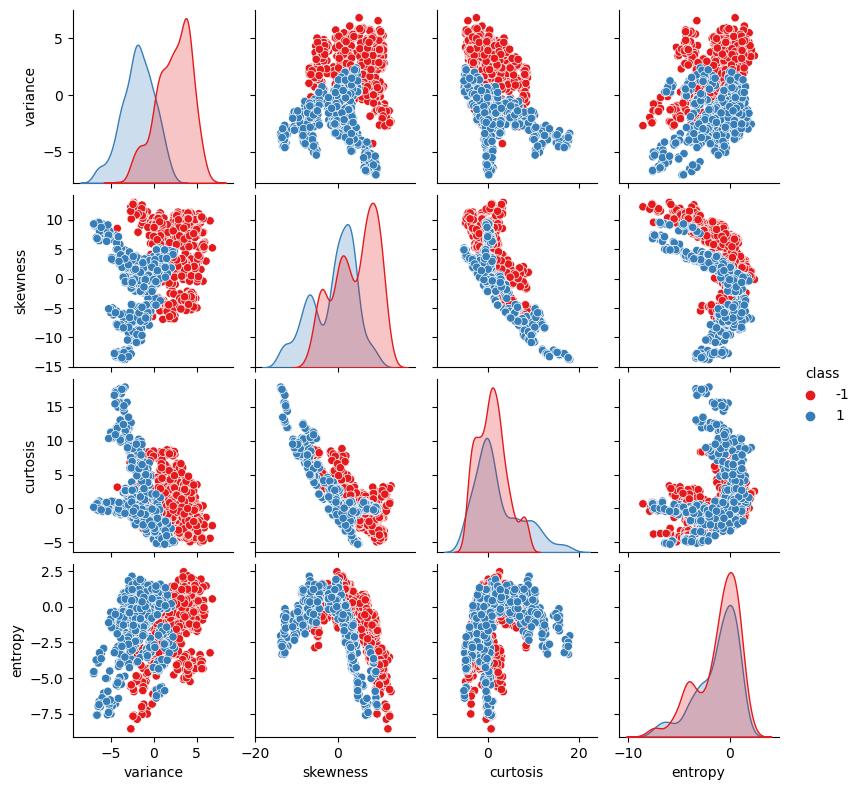

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df1, hue='class', palette="Set1", height=2)
plt.show()

<AxesSubplot: >

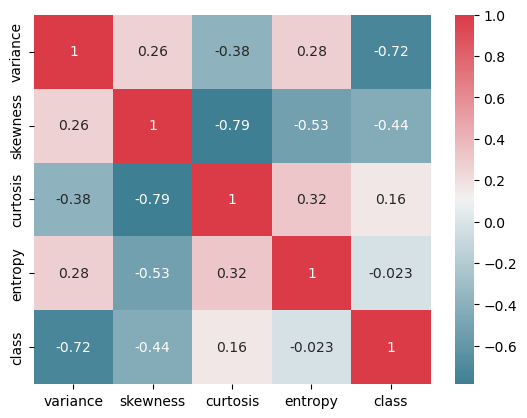

In [14]:
# Correlation matrix
sns.heatmap(df1.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

Considering the above plots, we notice that all the variables in our data set have a bell-shaped distribution, some skewed to the right (curtosis) and others to the left (variance, skewness and entropy). We see that the *variance* variable has a large negative correlation with the *class* target variable (-0.72); similarly the *skewness* and *curtosis* variables have a large negative correlation (-0.79). The *curtosis* and *entropy* variables have a very low correlation with our target variable (0.16 and -0.023, respectively), in theory, these two variables should not be considered as they may add noise to the model, however we will keep them and evaluate the model performance with all the original variables.

**Was the data randomly chosen?** To guarantee that a data set was randomly constructed, an experiment should have been created in which all possible events had the same probability of being chosen, minimising the risk of selection bias. An example of this type of experiment could have been to enumerate all possible samples and use a random number generator to know which ones to select <cite id="28quw"><a href="#zotero%7C14215332%2FKKMTMHB2">(Thomas, 2020)</a></cite>. Considering that we have no information on how this data set was collected, we can neither affirm nor deny that the set was randomly chosen. 

**Is this dataset linearly separable?** If this dataset is linearly separable, the SVM model should be able to find a hyperplane that separates the two classes of data. To see if the dataset 1 is linearly separable we will train the SVM model with all the samples and then we will study the accuracy of the results.

*What is accuracy?:* It is the ratio of number of correct predictions to the total number of input samples, that is:
$$ 
Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions made}}.
$$

If the model finds a hyperplane satifying the problem's hypotheses, all data samples should be classified in their corresponding class, meaning that the accuracy should be 100% or close to this value. Considering that achieving 100% accuracy with real data can be difficult even if the data is linearly separable (it depends on the model and the quality of the data), we will consider the data to be linearly separable if the accuracy is $\geq 98\%$.

In [11]:
# Set data values
X_1 = df1.copy().iloc[:, :-1].values # All data samples attributes
y_1 = df1.copy().iloc[:, -1].values # All data samples classes

In [58]:
svm1 = Support_Vector_Machine() # Create model
svm1.fit(X_1, y_1) # Train model

In [59]:
y_1_pred = svm1.predict(X_1) 

In [62]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_1, y_1_pred))

0.4446064139941691


In [88]:
svm1.w, svm1.b

(array([-9.25023946e-14, -9.25023946e-14, -9.25023946e-14, -9.25023946e-14]),
 89.63699999999238)

Since the model accuracy is 0.44 using this dataset, according to this model implementation the data is not linearly separable. We said before that the algorithm used can give us wrong results even for linearly separable data, so we will use the scikit-learn implementation to see how the model performs.

In [13]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_1, y_1)

#Predict the Test set results
y_1_pred_1 = classifier.predict(X_1)
print(accuracy_score(y_1, y_1_pred_1))

0.989067055393586


As we can see, the data is in fact linearly separable. Since the first SVM implementation did not work for this dataset, let's use the scikit-learn version to answer the last two questions related to this dataset.

**Show some examples to illustrate that the method is working properly**

To show that the method is working, we will train the model only with 80% of data, so we can use the remaining 20% to create the validation (10% of data) and test (10% of data) sets. After training the model, we will pick some examples of the validation set to show that the method is working.

*Note: We could also have chosen a 70-15-15 or 60-20-20 ratio, these will also be useful for our purpose and are commonly used in ML projects*.

In [25]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

In [26]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=test_ratio)

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train_1, y_train_1, 
                                                              test_size=validation_ratio/(train_ratio+test_ratio))

In [27]:
# Setting the kernel to 'linear' so we use the hard version of the SVM model
classifier_1 = SVC(kernel = 'linear', random_state = 0) 
classifier_1.fit(X_train_1, y_train_1)

SVC(kernel='linear', random_state=0)

Let's take some samples from the test data X_valid_1 and see if the model can predict properly their classes.

In [29]:
# We will choose the values in the entries number 2, 13 and 59.
test_prediction_2 = classifier.predict(X_valid_1[2].reshape(1, -1))
print("Test 1: Predicted value =", test_prediction_2[0], ", Expected result =", y_valid_1[2])
print("-------------------")


test_prediction_13 = classifier.predict(X_valid_1[13].reshape(1, -1))
print("Test 2: Predicted value =", test_prediction_13[0], ", Expected result =", y_valid_1[13])
print("-------------------")


test_prediction_59 = classifier.predict(X_valid_1[59].reshape(1, -1))
print("Test 3: Predicted value =", test_prediction_59[0], ", Expected result =", y_valid_1[59])
print("-------------------")

Test 1: Predicted value = 1 , Expected result = 1
-------------------
Test 2: Predicted value = 1 , Expected result = 1
-------------------
Test 3: Predicted value = -1 , Expected result = -1
-------------------


As we can see, on these three samples the model is working fine.

**Provide quantitative evidence for generalization using the provided dataset**

To show that the model is capable of generalization (it works with data never seen before), we will evaluate the accuracy of the model in the validation and test set.

In [32]:
y_pred_train_1 = classifier.predict(X_train_1)
print(f"The model accuracy in the train set is {accuracy_score(y_train_1, y_pred_train_1).round(3)*100}%")

The model accuracy in the train set is 98.9%


In [30]:
y_pred_val_1 = classifier.predict(X_valid_1)
print(f"The model accuracy in the validation set is {accuracy_score(y_valid_1, y_pred_val_1).round(3)*100}%")

The model accuracy in the validation set is 99.3%


The model accuracy in the validation set is not far from the accuracy in the train set and this one is very high, this indicates that the model is neither overfitting nor underfitting the data. Let's see the accuracy of the model with in the test dataset.

In [33]:
y_pred_test_1 = classifier.predict(X_test_1)
print(f"The model accuracy in the validation set is {accuracy_score(y_test_1, y_pred_test_1).round(3)*100}%")

The model accuracy in the validation set is 98.6%


The model was able to correctly predict almost all new data points. Let's see the confusion matrix for the prediction. A confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus, in binary classification the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$ <cite id="p3g2i"><a href="#zotero%7C14215332%2FIFSI4PWI">(<i>Sklearn.Metrics.Confusion_matrix</i>, n.d.)</a></cite>. In this way, we want the false positive $C_{0,1}$ and false negative $C_{1,0}$ values to be as low as possible.

In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_1, y_pred_test_1)

array([[68,  2],
       [ 0, 68]], dtype=int64)

In our case, $C_{1,0} = 0$ and $C_{0,1} = 2$, so almost all values were well classified.

## Dataset 2: Occupancy Detection Data Set
**Dataset description:** A set of images of a room were taken every minute, and from each of them, a set of attributes was extracted after processing the images. These attributes were used to determine whether the room was occupied or not. Three datasets are available: one for training and two for testing. One of the testing sets was obtained with the door of the room open, and the other one with the door closed (the training data was taken with the door closed).

**Dataset attributes**: 
1. Date time year-month-day hour:minute:second: Timestamp of the image taken.
2. Temperature (Celsius): Temperature of the room when the image was taken.
3. Relative Humidity (% of humidity): Percentage of humidity when the image was taken.
4. Light (Lux): Intensity of light when the image was taken. 
5. CO2 (in ppm): Amount of Carbon dioxide (CO2) per one million parts of air when the image was taken.
6. Humidity Ratio (derived quantity from temperature and relative humidity, measured in kgwater-vapor/kg-air): Ratio of the mass of water vapor in a given air sample to the mass of dry air in the same sample when the image was taken.
7. Occupancy: Indicates whether the room was occupied (1) in the image or not (0).

**Which problem are we trying to solve?**: As with Dataset 1, taking into account the description of the data, we will be solving a binary classification problem, where the main goal is to predict whether a room had people in it or not.

In [15]:
df2 = pd.read_csv("data/occupancy_data/datatraining.txt", sep=",")
df2 = df2.reset_index(drop=True)
df2.shape

(8143, 7)

**Is the sample size enough to guarantee generalization?**
Similar to data set 1, there is no formula for finding a value n for the sample size of the training set that will guarantee generalization, so we cannot say that the sample size of this data set will in fact ensure generalization.

In [16]:
df2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [17]:
df2.columns = [x.lower() for x in df2.columns] # Lowercase columns name for easy handling

target_distribution = pd.DataFrame(df2['occupancy'].value_counts())
target_distribution['percent'] = target_distribution['occupancy']/len(df2)*100
target_distribution['percent'] = target_distribution['percent'].round(3)
target_distribution

,occupancy,percent
0,6414,78.767
1,1729,21.233


In total, the data is almost split at a 80-20 ratio, meaning that in addition to the accuracy, it would be good to also test the model precision and recall, these are two classification metrics useful when the data is not uniform distributed related to its classes. 

As with dataset 1, we will chage the value of $0$ to $-1$ to meet our problem's requirements.

In [18]:
df2 = df2.replace({'occupancy': 0}, {'occupancy': -1})

target_distribution = pd.DataFrame(df2['occupancy'].value_counts())
target_distribution['percent'] = target_distribution['occupancy']/len(df2)*100
target_distribution['percent'] = target_distribution['percent'].round(3)
target_distribution

,occupancy,percent
-1,6414,78.767
1,1729,21.233


Let's study if the dataset has any null values, the attributes distributions including some plots of them against the occupancy values.

**Null values**

In [19]:
# Null values
get_missing_data_table(df2)

,TOTAL,PERCENTAGE
co2,0,0.0
date,0,0.0
humidity,0,0.0
humidityratio,0,0.0
light,0,0.0
occupancy,0,0.0
temperature,0,0.0


As before, it's good that our data does not have any missing value.

**Attributes distribution**

In [20]:
df2.iloc[:, :-1].describe()

,temperature,humidity,light,co2,humidityratio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863
std,1.016916,5.531211,194.755805,314.320877,0.000852
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,19.700000,20.200000,0.000000,439.000000,0.003078
50%,20.390000,26.222500,0.000000,453.500000,0.003801
75%,21.390000,30.533333,256.375000,638.833333,0.004352
max,23.180000,39.117500,1546.333333,2028.500000,0.006476


We note that the variables of *light* and *co2* can have big values (in this case, some of them are outliers) compared to *humidityratio*. Before training the model, we will need to scale all the variables.

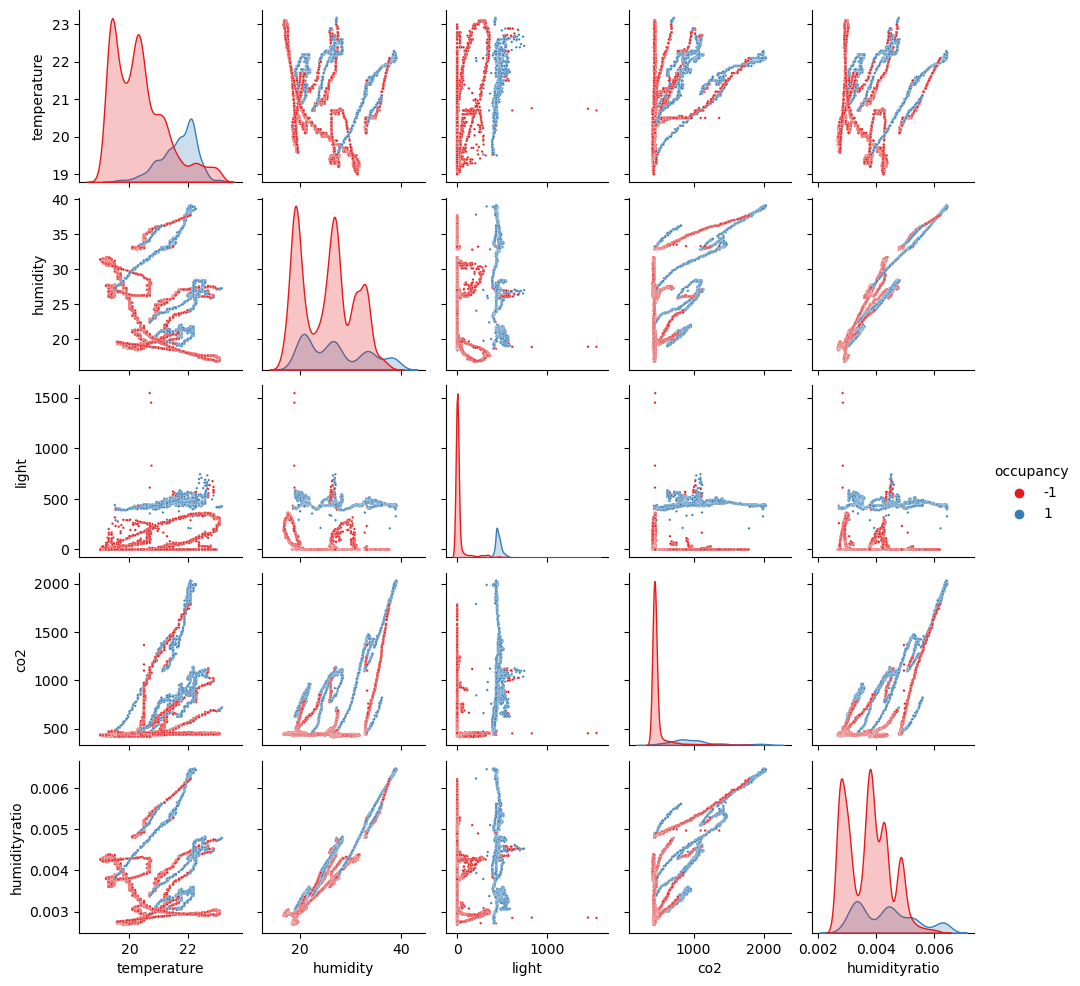

In [21]:
sns.pairplot(df2, hue='occupancy', palette="Set1", height=2, plot_kws={"s": 3})
plot_kws={"s": 3}
plt.show()

<AxesSubplot: >

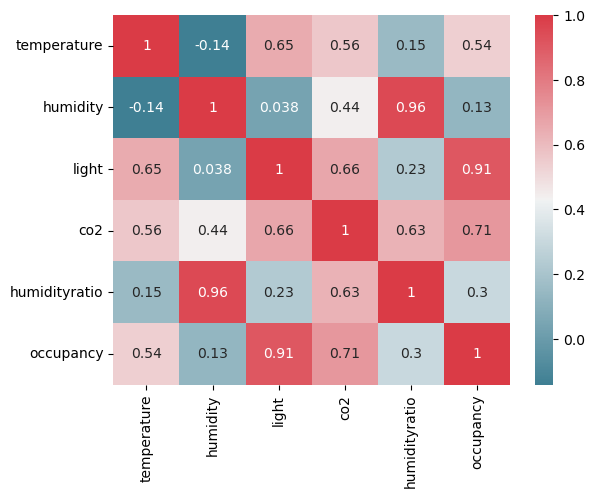

In [25]:
# Correlation matrix
sns.heatmap(df2.iloc[:, 1:] .corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

Observing the two previous graphs we can notice the following:
- By plotting the light variable with the other 4 variables, we can notice that it almost linearly separates the data, indicating that the higher the light concentrations, the higher the probability that the room is occupied. We can also see this by noting that the correlation between light and occupancy is 91%. This can be explained by the fact that since the study was conducted in an office, during the hours of greatest light (working hours) the room is occupied.
- The correlation between light and temperature is 65%, which makes sense since the more light there is in a room, the higher its temperature is.
- The busier the room, the higher the concentration of CO2 exhaled by humans in the breathing process, which explains the 71% correlation between these two variables.

**Was the data randomly chosen?** According to the definition of random sample we saw before, every sample of the population should have the same probability of being selected, that means that for this dataset we should have had photos taken in any moment in the time interval we had (one week) and not just every minute, which limits the moments where the images were taken, this means that this dataset was not randomly chosen.

Before seeing if the data is linearly separable, we need to make some changes to the *date* column. We will split this column into other two, one having relation with the day and the other one with the time at which the photo was taken. Let's see how many days are in the data.

In [31]:
print(f"The first day is {df2.date.min()} and the last day is {df2.date.max()}")

The first day is 2015-02-04 17:51:00 and the last day is 2015-02-10 09:33:00


As we saw, the time interval is only a week, so we will create another column indicating if the day was on the week (1) or on the weekend (0). For the time at which the photo was taken, we will convert it to the seconds elapsed from 12 am to the capture of the photo.

In [34]:
# Convert date to 1 if weekday or 0 if weekend
df2['weekday'] = pd.to_datetime(df2['date']).dt.dayofweek
df2['weekday'] = np.where(df2['weekday'] < 5, 1, 0)

In [35]:
# Convert hour to seconds elapsed from 12 am
df2['time'] = 3600*pd.to_datetime(df2['date']).dt.hour + 60*pd.to_datetime(df2['date']).dt.minute + \
              pd.to_datetime(df2['date']).dt.second

In [36]:
df2.head()

,date,temperature,humidity,light,co2,humidityratio,occupancy,weekday,time
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,1,64260
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,1,64319
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,1,64380
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,1,64440
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,1,64500


Since the date column was transformed, we can drop it from the dataset.

In [37]:
# Delete 'date' column from dataset 2
df2 = df2.drop(['date'], axis=1)

In [38]:
# Change column order so 'occupancy' is the last one
cols_list = df2.columns.tolist()
new_cols_list = cols_list[-2:] + cols_list[:-2]
df2 = df2[new_cols_list]
df2.head()

,weekday,time,temperature,humidity,light,co2,humidityratio,occupancy
0,1,64260,23.18,27.2720,426.0,721.25,0.004793,1
1,1,64319,23.15,27.2675,429.5,714.00,0.004783,1
2,1,64380,23.15,27.2450,426.0,713.50,0.004779,1
3,1,64440,23.15,27.2000,426.0,708.25,0.004772,1
4,1,64500,23.10,27.2000,426.0,704.50,0.004757,1


*Note: As with data set 1, we need to save df2 to use it in the next assignment.*

In [39]:
df2.to_pickle("./data/occupancy_data/datatraining.pkl") 

**Is the data linearly separable?**

As before, if the dataset is linearly separable, the SVM algorithm should find a hyperplane separating the data into two classes. We will first use the implementation we have of it, if this does not work, we will also test it with the scikit-learn version.


Before we run the algorithm, we should scale the data since there are variables with very large values and others with very small ones, this way the algorithm will not *think* that some variables are more important than others just based on their values.

In [44]:
#Feature scaling
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
X_2 = df2.copy().iloc[:,:-1]
X_2 = sc_x.fit_transform(X_2) # All data samples attributes scaled (standardization)
y_2 = df2.iloc[:, -1].values # All data samples classes

In [38]:
svm2 = Support_Vector_Machine() # Create model
svm2.fit(X_2, y_2) # Train model

In [40]:
y_2_pred = svm2.predict(X_2) 
print(accuracy_score(y_2, y_2_pred))

0.2123296082524868


Since the model accuracy is 0.21 using this dataset, it means that this model was not able to find a hyperparameter to separate the data. Let's use the scikit-learn version to see its performance.

In [45]:
classifier_2 = SVC(kernel = 'linear', random_state = 0)
classifier_2.fit(X_2, y_2)

#Predict the Test set results
y_2_pred_2 = classifier_2.predict(X_2)
print(accuracy_score(y_2, y_2_pred_2))

0.9888247574603954


We can see that the data is indeed linearly separable. Since the first SVM implementation did not work for this dataset, for the last two question we will use the scikit-learn implementation.

**Show some examples to illustrate that the method is working properly**

As before, to show that the method is working, we will need to train the model with a set of data and then test it with samples it has never seen before. For this problem we have two test datasets, so we will not need to split the data in train, test and validation, we will use the first test data as our validation set and the second test data as our test set. Before studying the model's accuracy, we need to do the same transformations to both test datasets as we did to the training data.

***Data preprocessing***

In [47]:
# Importing data and resetting the index
X_2_valid = pd.read_csv("data/occupancy_data/datatest.txt", sep=",") # Data taken with the door closed
X_2_valid = X_2_valid.reset_index(drop=True)

X_2_test = pd.read_csv("data/occupancy_data/datatest2.txt", sep=",") # Data taken with the door open
X_2_test = X_2_test.reset_index(drop=True)

In [48]:
# Lowercase columns names
X_2_valid.columns = [x.lower() for x in X_2_valid.columns] 
X_2_test.columns = [x.lower() for x in X_2_test.columns]

In [49]:
# Replacing 0 for -1 in the 'occupancy' column
X_2_valid = X_2_valid.replace({'occupancy': 0}, {'occupancy': -1})
X_2_test = X_2_test.replace({'occupancy': 0}, {'occupancy': -1})

In [50]:
# Convert date to 1 if weekday or 0 if weekend
X_2_valid['weekday'] = pd.to_datetime(X_2_valid['date']).dt.dayofweek
X_2_valid['weekday'] = np.where(X_2_valid['weekday'] < 5, 1, 0)

X_2_test['weekday'] = pd.to_datetime(X_2_test['date']).dt.dayofweek
X_2_test['weekday'] = np.where(X_2_test['weekday'] < 5, 1, 0)

In [51]:
# Convert hour to seconds elapsed from 12 am
X_2_valid['time'] = 3600*pd.to_datetime(X_2_valid['date']).dt.hour + 60*pd.to_datetime(X_2_valid['date']).dt.minute + \
                  pd.to_datetime(X_2_valid['date']).dt.second

X_2_test['time'] = 3600*pd.to_datetime(X_2_test['date']).dt.hour + 60*pd.to_datetime(X_2_test['date']).dt.minute + \
                  pd.to_datetime(X_2_test['date']).dt.second

In [52]:
# Delete 'date' column 
X_2_valid = X_2_valid.drop(['date'], axis=1)
X_2_test = X_2_test.drop(['date'], axis=1)

In [53]:
# Change column order so 'occupancy' is the last one
cols_list_1 = X_2_valid.columns.tolist()
new_cols_list_1 = cols_list_1[-2:] + cols_list_1[:-2]

X_2_valid = X_2_valid[new_cols_list_1]
X_2_test = X_2_test[new_cols_list_1]

In [54]:
# Saving modified data sets
X_2_valid.to_pickle("./data/occupancy_data/datatest.pkl") 
X_2_test.to_pickle("./data/occupancy_data/datatest2.pkl") 

In [56]:
# Feature Scaling
# We use the scaler object created with the train data
y_2_valid = X_2_valid.iloc[:, -1].values
X_2_valid = sc_x.transform(X_2_valid.copy().iloc[:, :-1]) 

y_2_test = X_2_test.iloc[:, -1].values
X_2_test = sc_x.transform(X_2_test.copy().iloc[:, :-1])

In [58]:
# Examples with validation data 
# We will choose the values in the entries number 2 and 13.
test_prediction_2 = classifier_2.predict(X_2_valid[2].reshape(1, -1))
print("Test 1: Predicted value =", test_prediction_2[0], ", Expected result =", y_2_valid[2])
print("------------------- \n")

test_prediction_13 = classifier_2.predict(X_2_valid[13].reshape(1, -1))
print("Test 2: Predicted value =", test_prediction_13[0], ", Expected result =", y_2_valid[13])
print("------------------- \n\n")

test_prediction_59 = classifier_2.predict(X_2_valid[59].reshape(1, -1))
print("Test 3: Predicted value =", test_prediction_59[0], ", Expected result =", y_2_valid[59])
print("-------------------")

Test 1: Predicted value = 1 , Expected result = 1
------------------- 

Test 2: Predicted value = 1 , Expected result = 1
------------------- 


Test 3: Predicted value = 1 , Expected result = 1
-------------------


For all the tested samples, the model correctly predicted the class they belong to.

**Provide quantitative evidence for generalization using the provided dataset**

To show the model can generalize, we will need evaluate the accuracy of the model in both validation and test set.

In [59]:
# Accuracy for test data 1
y_2_pred_1 = classifier_2.predict(X_2_valid)
print(f"The model accuracy in the validation set is {accuracy_score(y_2_valid, y_2_pred_1).round(3)*100}%")

The model accuracy in the validation set is 97.89999999999999%


The model accuracy in the validation set is very close from the accuracy obtained in the train set, since both are high and close to each other, we can affirm that the model is neither overfitting or underfitting the data. Let's see what is the model accuracy for the test dataset.

In [61]:
# Accuracy for test data 2
y_2_pred_2 = classifier_2.predict(X_2_test)
print(f"The model accuracy in the test set is {accuracy_score(y_2_test, y_2_pred_2).round(3)*100}%")

The model accuracy in the test set is 99.1%


We note that the accuracy is almost perfect in thi dataset, indicating that the model is good at generalizing. Let us look at the confusion matrices for the prediction.

In [62]:
print("Confusion matrix for test data 1")
confusion_matrix(y_2_test, y_2_pred_2)

Confusion matrix for test data 1


array([[7624,   79],
       [   5, 2044]], dtype=int64)

With the test data, the model made more mistakes than with validation set, here 79 samples were misclassify as false positives (the model predicted that the room was occupied when it was not) and 5 as false negatives (the model predicted that the room was not occupied when it did was). Let's explore the model's precision and recall.

In [64]:
from sklearn.metrics import precision_score, recall_score

print(f"The model precision is {precision_score(y_2_test, y_2_pred_2)}, and the model recall is {recall_score(y_2_test, y_2_pred_2)}")

The model precision is 0.9627885068299576, and the model recall is 0.997559785261103


A recall of almost 100% means that of all the positive values (the room was occupied), the model predicted almost all of them well (it was wrong only in 5 test samples). 

# Conclusions
1. Support Vector Machine is a very powerful Machine Learning model, but if the data is not linearly separable, it would not work.
2. It is mandatory to always do an Exploratory Data Analysis in order to understand the data we are working with, this is one of the most important parts in Machine Learning.
3. All Machine Learning models operate under the assumption that new data will behave similarly to the training data, otherwise the model metrics will always be low.

# Bibliography
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|14215332/PR5M3MS2"></i><ul>
    <li>Brownlee, J. (2019, May 23). <i>How Much Training Data is Required for Machine Learning?</i> Machine Learning Mastery. <a href="https://machinelearningmastery.com/much-training-data-required-machine-learning/">https://machinelearningmastery.com/much-training-data-required-machine-learning/</a></li>
</ul></div>
  <div class="csl-entry"><i id="zotero|14215332/Q7QXGZ6I"></i><ul><li>Chapter 3 - Compositing, smoothing, and gap-filling techniques. (2020). In <i>Advanced Remote Sensing</i> (Vol. 2). Elsevier.</li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/V9BN9UHV"></i><ul><li>Dattorro, J. (2019). <i>Convex Optimization and Euclidian Distance Geometry</i>.</li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/N5CVPJUC"></i><ul><li>Dorfman, E. (2022, March 25). <i>How Much Data Is Required for Machine Learning?</i> Postindustria. <a href="https://postindustria.com/how-much-data-is-required-for-machine-learning/">https://postindustria.com/how-much-data-is-required-for-machine-learning/</a></li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/WXZ9VFIK"></i><ul><li>P. de B. Harrington. (2016). Chapter 9 - Multivariate Curve Resolution of Wavelet Compressed Data. In <i>Data Handling in Science and Technology</i> (Vol. 30).</li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/IFSI4PWI"></i><ul><li>sklearn.metrics.confusion_matrix. (n.d.). Scikit-Learn. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html">https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html</a></li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/P94ZMVC2"></i><ul><li>Talebi, S. (2020, December 20). <i>The Wavelet Transform</i>. Towards Data Science. <a href="https://towardsdatascience.com/the-wavelet-transform-e9cfa85d7b34">https://towardsdatascience.com/the-wavelet-transform-e9cfa85d7b34</a></li></ul></div>
  <div class="csl-entry"><i id="zotero|14215332/KKMTMHB2"></i><ul><li>Thomas, L. (2020, May 3). <i>Simple Random Sampling | Definition, Steps &#38; Examples</i>. Scribbr. <a href="https://www.scribbr.co.uk/research-methods/simple-random-sampling-method/">https://www.scribbr.co.uk/research-methods/simple-random-sampling-method/</a></li></ul></div>
</div>
<!-- BIBLIOGRAPHY END -->